# Decision Trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
iris = load_iris()

plt.rcParams["figure.figsize"] = (8, 5)

In [29]:
iris = load_iris()
X, y = iris.data[:,2:], iris.target
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

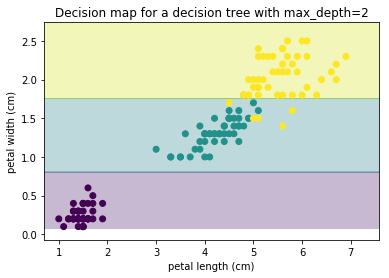

In [31]:
x1min, x2min = X.min(axis=0) * 0.7
x1max, x2max = X.max(axis=0) * 1.1

x1map, x2map = np.mgrid[x1min:x1max:0.01, x2min:x2max:0.01]
xpred = np.c_[x1map.reshape(-1,1), x2map.reshape(-1,1)]
ypred = tree_clf.predict(xpred).reshape(x1map.shape)
plt.contourf(x1map, x2map, ypred, alpha=0.3)
plt.scatter(*X.T, c=y)
plt.title(f"Decision map for a decision tree with max_depth={max_depth}")
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3]);

> Traversing the Decision Tree requires going through roughly $O(\log_2(m))$ nodes

In [37]:
iris["target"].shape

(150,)

In [39]:
np.log2(iris["target"].shape[0])

7.2288186904958804

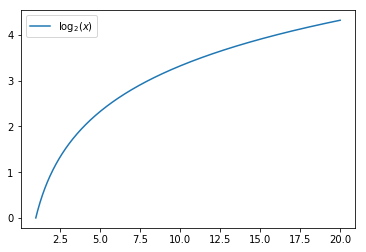

In [47]:
xrange = np.linspace(1, 20, 500)
plt.plot(xrange, np.log2(xrange), label="$\log_2(x)$")
plt.legend()
plt.show()

In [32]:
# Probability of a classification is the "impurity" when classifying
tree_clf.predict_proba([[5, 1.5]]), tree_clf.predict_proba([[5, 1]])

(array([[ 0.        ,  0.90740741,  0.09259259]]),
 array([[ 0.        ,  0.90740741,  0.09259259]]))

In [33]:
export_graphviz(
    tree_clf,
    out_file="./images/iris_tree.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [34]:
%%bash
dot -Tpng "./images/iris_tree.dot" -o "./images/iris_tree.png"

<img style="center" src="./images/iris_tree.png">

In [142]:
g1 = 1 - ((0 / 54) ** 2 + (49 / 54) ** 2 + (5 / 54) ** 2)
print(f"Gini score for bottom left leaf: {g1:0.5f}")

Gini score for bottom left leaf: 0.16804


## Exercises

**1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with 1 million instances?**

The approximate depth of a Decisión tree is $O(\log(m))$. Therefore, the depth of a decision tree trained on 1 million instances would be approximately $\log(1,000,000) \approx 19.93$

---
**2. Is a node’s Gini impurity generally lower or greater than its parent’s? Is it generally lower/greater, or always lower/greater?**

The purity in a node of a tree, considering the Gini impurity, is **generally** *lower* than its parents.

---
**If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?**

In [107]:
np.log2(1e6)

19.931568569324174

## Some notes on the big-$O$ notation
By [Rob Bell](https://rob-bell.net/2009/06/a-beginners-guide-to-big-o-notation/)

In [65]:
randn_small = np.random.randn(10)
randn_big = np.random.randn(100_000)

>Big O specifically describes the worst-case scenario, and can be used to describe the execution time required or the space used (e.g. in memory or on disk) by an algorithm.m

> $O(1)$ describes an algorithm that will always execute in the same time (or space) regardless of the size of the input data set.

In [54]:
def is_first_zero(array):
    return array[0] == 0

In [66]:
%%timeit -n 30
is_first_zero(randn_small)

463 ns ± 104 ns per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [67]:
%%timeit -n 30
is_first_zero(randn_big)

461 ns ± 97.5 ns per loop (mean ± std. dev. of 7 runs, 30 loops each)


> $O(N)$ describes an algorithm whose performance will grow linearly and in direct proportion to the size of the input data set.

For the follwing scenario, even though the program might return `True` before visiting every value in the array, we consider **the worst case scenario**

In [52]:
def array_has_value(array, value):
    for val in array:
        if val == value:
            return True
    return False

In [71]:
%%timeit -n 30
array_has_value(randn_small, 3)

3.87 µs ± 448 ns per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [72]:
%%timeit -n 30
array_has_value(randn_big, 3)

18.4 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


> $O(N^2)$ represents an algorithm whose performance is directly proportional to the square of the size of the input data set.

Common when iterating the same list twice

In [76]:
def has_duplicates(array):
    for ix1, el1 in enumerate(array):
        for ix2, el2 in enumerate(array):
            if (el1 == el2) and (ix1 != ix2):
                return True
    return False

> $O(2^N)$ denotes an algorithm whose growth doubles with each additon to the input data set. 

in the following example, once we start with a number, it creates a tree with two nodes, each one of those nodes create another two nodes and so on. Totalling $2^N$ values

In [79]:
def fibo(number):
    if number <= 1:
        return number
    else:
        return fibo(number - 2) + fibo(number - 1)

In [97]:
format(2 ** 1, ",")

'2'

In [95]:
format(2 ** 10, ",")

'1,024'

In [96]:
format(2 ** 100, ",")

'1,267,650,600,228,229,401,496,703,205,376'

In [98]:
format(2 ** 1000, ",")

'10,715,086,071,862,673,209,484,250,490,600,018,105,614,048,117,055,336,074,437,503,883,703,510,511,249,361,224,931,983,788,156,958,581,275,946,729,175,531,468,251,871,452,856,923,140,435,984,577,574,698,574,803,934,567,774,824,230,985,421,074,605,062,371,141,877,954,182,153,046,474,983,581,941,267,398,767,559,165,543,946,077,062,914,571,196,477,686,542,167,660,429,831,652,624,386,837,205,668,069,376'

> $O(\log n)$

In [102]:
np.log10(10)

1.0

In [103]:
np.log10(100)

2.0

In [104]:
np.log10(1000)

3.0

In [105]:
np.log10(100000)

5.0